In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download andrewmvd/trip-advisor-hotel-reviews

In [ ]:
import zipfile
zip_ref =  zipfile.ZipFile(r'/content/trip-advisor-hotel-reviews.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.2 MB/s eta 0:00:00


### Introduction
Customer reviews are a rich source of insights for understanding customer sentiments and improving services in the hospitality industry. In this project, we analyzed hotel reviews from the [TripAdvisor Hotel Reviews dataset](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews). The primary objective was to uncover patterns and themes within **negative reviews** using Natural Language Processing (NLP) techniques and clustering methods.

The workflow involved:
1. **Preprocessing the data** using `spaCy` for cleaning and lemmatization.
2. **Sentiment analysis** using `SentimentIntensityAnalyzer` to categorize reviews into positive, neutral, and negative sentiments.
3. **Vectorization** of the negative reviews using `TfidfVectorizer` to transform text into numerical data suitable for clustering.
4. **Optimal cluster selection** using `Stellhouse_score` to determine the ideal number of clusters.
5. **K-means clustering** to identify common themes in the negative reviews, resulting in three distinct clusters representing recurring issues experienced by customers.

This analysis helps highlight the key areas of dissatisfaction among hotel guests, providing actionable insights for hotel management to improve customer satisfaction.


### Import Libraries:

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis:

In [ ]:
df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
# Finding the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Note that Dataset contains two columns (Review and rating). Howeverm our goal is to find categories in the negative reviews. Hence, we will need only Review Column.

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Remove The URL
def remove_url(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if not token.text.startswith(('http', 'www'))]
  return ' '.join(filtered)

# Remove the URL
def remove_emoji(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if token.is_ascii]
  return ' '.join(filtered)

# Remove Punctuations and  Characters
def remove_punctuation_characters(text):
  doc = nlp(text)
  filtered = [token.text for token in doc if token.is_alpha]
  return ' '.join(filtered)

# Remove Extra Spaces
def remove_extra_spaces(text):
  return ' '.join(text.split())

# Clean the Text
def clean_text(text):
  if isinstance(text , str):
    text = text.lower()
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_punctuation_characters(text)
    text = remove_extra_spaces(text)
    return text

df['Review'] = df['Review'].apply(clean_text)
df['Review'].iloc[0]

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay parking night'

In [ ]:
# Lemmatization and Remove Stop Words
def lemmatization(text):
  doc = nlp(text)
  lemmatized_token = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
  return ' '.join(lemmatized_token)

df['Review_lemmatized'] = df['Review'].apply(lemmatization)
df['Review_lemmatized'].iloc[0]

'nice hotel expensive parking get good deal stay hotel anniversary arrive late evening take advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable wake stiff neck high pillow soundproof like hear music room night morning loud bang door open closing hear people talk hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch take advantage stay long location great walk distance shop overall nice experience having pay parking night'

In [ ]:
# Creating the Sentiment Categories
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment'] = df['Review_lemmatized'].apply(get_sentiment)
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Review,Rating,Review_lemmatized,Sentiment
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...,positive
1,ok nothing special charge diamond member hilto...,2,ok special charge diamond member hilton decide...,positive
2,nice rooms not experience hotel monaco seattle...,3,nice room experience hotel monaco seattle good...,positive
3,unique great stay wonderful time hotel monaco ...,5,unique great stay wonderful time hotel monaco ...,positive
4,great stay great stay went seahawk game awesom...,5,great stay great stay go seahawk game awesome ...,positive


In [ ]:
# Now Take only the negative Sentiment
data = df[df['Sentiment'] == 'negative']

vectorizer = TfidfVectorizer(max_features = 500)
X = vectorizer.fit_transform(data['Review_lemmatized'])

In [ ]:
from sklearn.metrics import silhouette_score
# Assuming you have your data in a NumPy array 'X'

# Create a list to store silhouette scores for different k values
silhouette_scores = []

# Test different k values (e.g., from 2 to 10)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)  # Set random_state for reproducibility
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the k value with the highest silhouette score
best_k = np.argmax(silhouette_scores) + 2  # Add 2 because k starts from 2

print(f"Optimal number of clusters (based on silhouette score): {best_k}")

Optimal number of clusters (based on silhouette score): 3


In [ ]:
# K-Means clustering
num_clusters = best_k  # Adjust based on data exploration
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign each review to a cluster
clusters = kmeans.predict(X)
print("Cluster Assignments:", clusters)


Cluster Assignments: [2 2 0 0 0 2 2 0 2 2 2 0 0 2 2 2 0 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 2 0 0 0 0
 2 0 0 2 2 0 0 0 2 0 0 0 1 0 0 2 0 2 0 2 2 0 2 0 2 2 2 2 2 0 2 1 2 2 2 2 0
 2 0 2 0 1 1 0 0 2 0 0 2 0 2 2 2 2 0 1 2 0 0 1 1 0 2 0 0 2 2 0 2 0 0 0 0 0
 2 0 0 2 2 2 0 2 0 2 2 2 2 2 0 2 2 2 2 2 2 0 0 0 0 2 0 0 2 2 2 2 2 2 1 0 0
 2 2 0 2 2 2 2 2 2 2 2 0 2 0 0 2 0 1 0 2 1 1 0 1 0 2 1 1 2 2 1 1 1 1 1 1 1
 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 2 2 1 0 0 2 2 0 1 2
 0 2 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 2 0 2 0 2 0 2 0 2 2 1 2 2 0 0
 1 0 0 2 0 0 2 2 0 0 0 0 0 2 2 2 0 0 0 0 2 0 2 2 2 0 0 2 1 0 0 2 0 2 0 2 0
 0 2 0 2 0 2 1 0 2 2 2 0 0 2 2 2 0 0 1 2 1 1 1 1 1 1 1 1 1 2 0 0 0 2 2 0 0
 0 2 2 0 0 1 0 0 2 0 2 2 0 0 2 0 2 0 2 0 0 2 2 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 2 1 1 1 1 0 1 2 0 2 2 0 2 2 0 1 0 2 2 0 0 0 2 0 0 2 0 2 2 2 2 2 2 2
 2 0 2 0 1 2 1 1 2 0 2 0 1 2 0 2 0 2 0 2 0 2 0 0 0 2 2 0 0 2 0 0 1 0 0 0 2
 0 2 2 0 0 0 0 2 2 0 2 0 2 0 0 0 2 0 0 0 2 2 2 0 2 0 2 0 0 2 0 2 2 2 2 0 2
 2 0

In [ ]:
# Top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(", ".join(terms[ind] for ind in order_centroids[i, :10]))  # Top 10 terms


Cluster 0:
hotel, room, stay, service, staff, night, check, book, tell, day
Cluster 1:
food, resort, beach, room, bad, restaurant, day, hotel, people, service
Cluster 2:
room, hotel, stay, night, bed, place, bad, dirty, bathroom, small


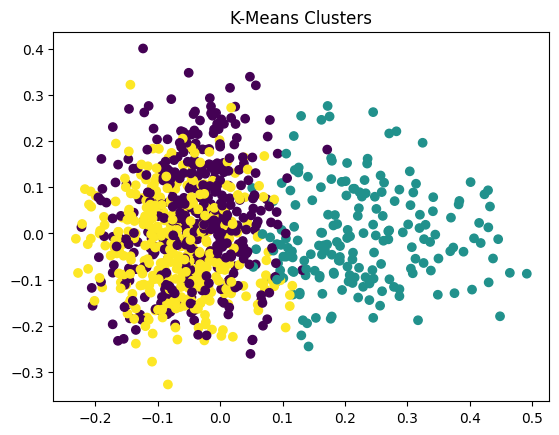

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Plot clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
plt.title("K-Means Clusters")
plt.show()


- Cluster 0:
This cluster emphasizes issues related to the hotel service experience, such as problems with staff, booking, and check-ins. Words like hotel, room, stay, service, and staff suggest the reviews in this group likely describe frustrations with general hotel operations, staff behavior, and the booking/check-in process.

- Key takeaway: These reviews are likely focused on customer service and operational inefficiencies.

- Cluster 1:
This cluster revolves around the food, dining experience, and environment of the hotel, such as issues with the resort, beach, restaurant, or food quality. Words like food, resort, beach, and bad suggest that guests were dissatisfied with dining options, food quality, or perhaps their overall experience at the resort.

- Key takeaway: These reviews highlight dissatisfaction with the hotel’s food offerings, resort environment, or restaurant services.

- Cluster 2:
This cluster focuses on room-related complaints, particularly about the condition of the rooms. Words like dirty, bathroom, bed, and small point to issues such as cleanliness, room size, and maintenance.

- Key takeaway: These reviews are primarily about the physical aspects of the hotel rooms and their inadequacies.



### Conclusion
The clustering analysis revealed three main themes in negative reviews:

1. **Cluster 0:** Focused on issues related to **customer service and hotel operations**, such as inefficient check-ins, unhelpful staff, and booking problems.
2. **Cluster 1:** Highlighted dissatisfaction with the **food, dining experience, and resort environment**, including complaints about food quality, restaurant service, and resort amenities.
3. **Cluster 2:** Centered on **room-related problems**, with recurring complaints about cleanliness, room size, and poor maintenance.

These findings provide valuable insights for hotel management to identify and prioritize key areas for improvement.
- Improving customer service by training staff and streamlining booking and check-in processes.
- Enhancing food quality and maintaining resort amenities to provide a better overall experience.
- Ensuring regular maintenance and cleanliness of hotel rooms to meet customer expectations.

By addressing these issues, hotels can improve customer satisfaction and potentially increase positive reviews, leading to better brand reputation and customer loyalty.
